In [9]:
# Descriptive statistics table (standalone)
import os
import numpy as np
import pandas as pd

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS  = None   # e.g. ['ABBV','AMGN', ...] or None to auto-discover
SAVE_CSV = "descriptive_stats.csv"     # set to None to skip saving

# -------- helpers --------
def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    df = pd.read_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), parse_dates=["Date"]).sort_values("Date")
    # Expect columns: Date, Close, Volume, ...
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change()
    df["Ticker"] = ticker
    return df[["Date","Ticker","ret"]]

# -------- compute returns --------
tickers = TICKERS or list_tickers(DATA_DIR)
rets = pd.concat([load_one(t) for t in tickers])
daily_pct_change = rets.pivot(index="Date", columns="Ticker", values="ret").sort_index()

# -------- table --------
stats = daily_pct_change.describe().T.rename(
    columns={"count":"Obs","mean":"Mean","std":"σ","min":"Min","max":"Max"}
)[["Obs","Mean","σ","Min","Max"]].round(6)

# optional placeholders (remove if you don't need)
stats["Unit root"] = np.nan
stats["Mcap"] = np.nan
stats = stats[["Obs","Mean","σ","Min","Max",]]

display(stats.style.set_caption(
    "Table: Descriptive statistics for the daily returns of the assets"
))

if SAVE_CSV:
    stats.to_csv(SAVE_CSV)
    print(f"Saved: {SAVE_CSV}")


,Obs,Mean,σ,Min,Max
Ticker,,,,,
ABBV,2515.000000,0.000538,0.016871,-0.162524,0.137673
AMGN,2515.000000,0.000316,0.015631,-0.095846,0.118180
AZN,2515.000000,0.000369,0.015554,-0.149087,0.092947
BIIB,2515.000000,0.000018,0.026568,-0.292305,0.439739
BMY,2515.000000,0.000102,0.015569,-0.159851,0.114425
GILD,2515.000000,0.000121,0.016214,-0.101501,0.129202
GSK,2515.000000,-0.000001,0.013303,-0.110436,0.094446
JNJ,2515.000000,0.000194,0.011404,-0.100379,0.079977
LLY,2515.000000,0.001107,0.017567,-0.105145,0.156798


Saved: descriptive_stats.csv


Saved: daily_returns_grid_all_years.png


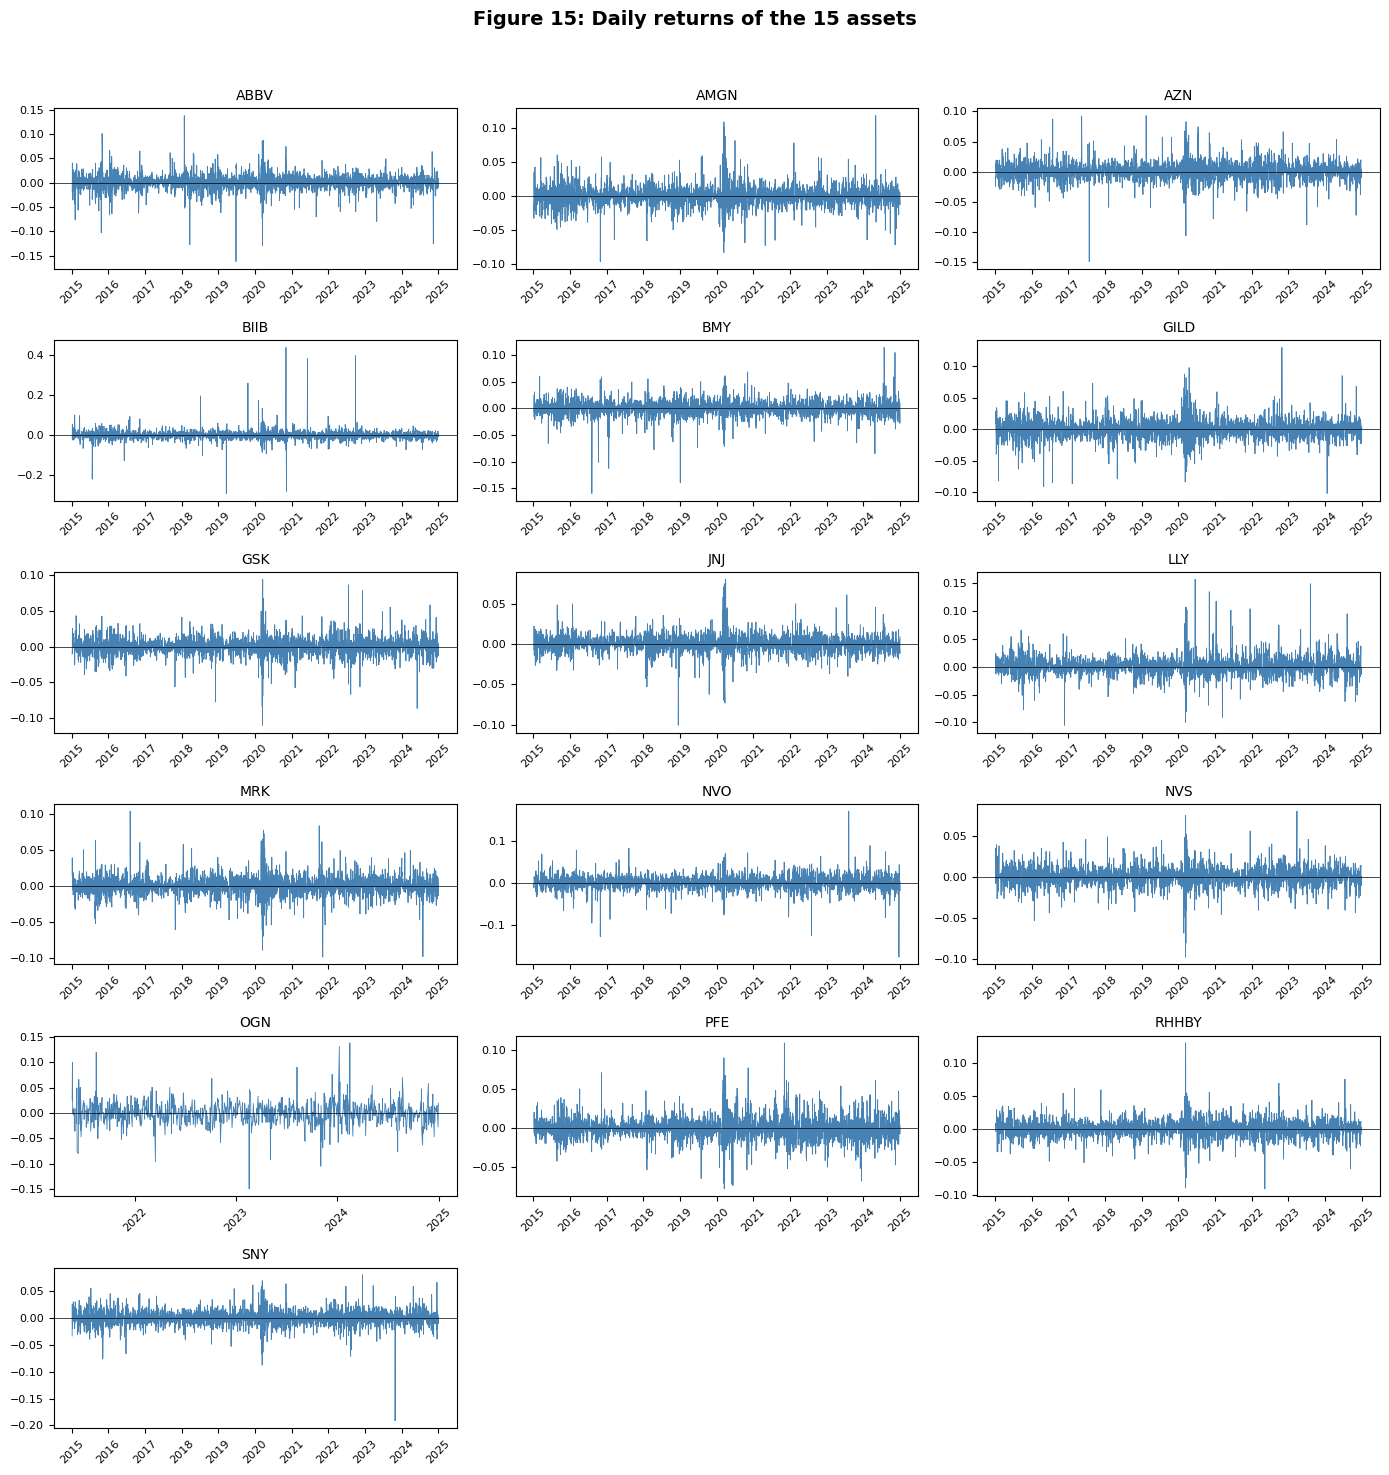

In [10]:
# Daily returns subplots (final improved version)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS  = None       # e.g. ['ABBV','AMGN', ...] or None to auto-discover
SAVE_PNG = "daily_returns_grid_all_years.png"   # set to None to skip saving

# -------- helpers --------
def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    df = pd.read_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), parse_dates=["Date"]).sort_values("Date")
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change()
    df["Ticker"] = ticker
    return df[["Date","Ticker","ret"]]

# -------- compute returns --------
tickers = TICKERS or list_tickers(DATA_DIR)
rets = pd.concat([load_one(t) for t in tickers])
daily_pct_change = rets.pivot(index="Date", columns="Ticker", values="ret").sort_index()

# -------- grid setup --------
n = len(daily_pct_change.columns)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.5), sharex=False)
axes = np.atleast_1d(axes).ravel()

# -------- plot --------
for i, t in enumerate(daily_pct_change.columns):
    ax = axes[i]
    ax.plot(daily_pct_change.index, daily_pct_change[t], linewidth=0.6, color="steelblue")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(t, fontsize=10)
    
    # Format x-axis for all subplots
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Figure 15: Daily returns of the 15 assets", fontsize=14, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])

if SAVE_PNG:
    fig.savefig(SAVE_PNG, dpi=200, bbox_inches="tight")
    print(f"Saved: {SAVE_PNG}")

plt.show()
